In [31]:
import numpy as np
import pandas as pd
import warnings
from scipy.stats import chi2_contingency
from scipy import stats
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

1 Read the dataset 
========

In [2]:
data = pd.read_csv("../../sep19SexAndAgeAddedFINAL DATASET_ver2.txt", sep=",")

In [3]:
# change field 38 to 3 group

condtion = [
    data.FIELD_38 == 0,
    (data.FIELD_38 > 0) & (data.FIELD_38 < 4),
    data.FIELD_38 >= 4,
]
choice = [0, 1, 2]
data["FIELD_38_C"] = np.select(condtion, choice, default=np.nan)

In [4]:
# #change physical excercise fields to one group
# # FIELD_40	6-1 of physical activity (high strength) class=2
# # FIELD_41	6-2 of physical activity (moderate) class=2
# # FIELD_42	6-3 of physical activity (walking) class=2
# # No Physical acitvity class=0

# phActivity=[]
# for i in range(data.shape[0]):
#     if( not(np.isnan(data.FIELD_40[i])) or not(np.isnan(data.FIELD_40[i])) or not(np.isnan(data.FIELD_40[i])) ):
#         if()

In [5]:
data["max"] = np.min(
    data[["FIELD_6", "FIELD_7"]], axis=1
)  # combine FIELD_6 and FIELD_7 both represent the same thing (Women's marital status)
data = data.drop(columns=["FIELD_6", "FIELD_7", "B_DAY"])
print(data.shape)

(535169, 405)


In [6]:
# add Class to the dataset
_class = []
for i in range(data.shape[0]):
    if (data.S000501[i] >= 140) | (data.S000502[i] >= 90):
        _class.append(2)
    elif (data.S000501[i] < 120) & (data.S000502[i] < 80):
        _class.append(0)
    else:
        _class.append(1)
data["CLASS"] = _class

In [7]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia
print(data.shape)

(466680, 406)


In [8]:
# rename columns
data.rename(
    columns={
        "L104600": "HBA1C",
        "L103000": "Triglycerides",
        "L100800": "fasting glucose",
        "S000300": "BMI",
        "S000501": "SBP",
        "S000502": "DBP",
        "L101700": "r-GTP gamma",
        "L103300": "Cardiac risk factor",
        "L190400": "Hemoglobin",
        "L190500": "HCT",
        "L100700": "Uric Acid",
        "L101300": "SGPT",
        "L190300": "RBC",
        "L102900": "total cholesterol",
        "L103100": "HDL-Cholesterol",
    },
    inplace=True,
)

In [9]:
# split column types to categorical and numerical
numerical_cols = list(data.columns[~data.columns.str.startswith("FIELD")])
categorical_cols = list(data.columns[data.columns.str.startswith("FIELD")])
categorical_cols.append("CLASS")
numerical_cols.remove("SEX")
categorical_cols.append("SEX")

2 Feature Selection
===========

2.1 Calculate correlation Value - for numerical values
========

2.1.1 Pearson Correlation
======

In [ ]:
corr = data[numerical_cols].corr()  # compute the correlation value
corr = corr.CLASS  # select the correlation values of the Class

# convert correlation values to dataframe
corrvalPD = pd.DataFrame()
corrvalPD["Col"] = corr.index
corrvalPD["val"] = abs(corr.values)

corrvalPD = corrvalPD.sort_values(by="val", ascending=False)
corrvalPD.head()

In [ ]:
# get count of none NA values of each feature set
mydataset = data.copy()[numerical_cols]
colCount = []
for i in mydataset.columns:
    colCount.append([i, mydataset[i].dropna().shape[0]])

colCountPD = pd.DataFrame(colCount, columns=["Col", "Count"])
colCountPD.head()

In [ ]:
# merge the correlation value and the total count of the feature
mergedColCorrCount = pd.merge(
    corrvalPD, colCountPD, how="inner", left_on="Col", right_on="Col"
)
mergedColCorrCount = mergedColCorrCount[mergedColCorrCount.Count > 50000]
mergedColCorrCount = mergedColCorrCount.sort_values(by="val", ascending=False)
mergedColCorrCount.head(10)

In [ ]:
# select top 20 correlated features
print(list(mergedColCorrCount.head(16).Col))

2.1.2 Anova test
=======

In [ ]:
# another option for feature selection of numerical values

mydataset = data.copy()[numerical_cols]  # filter only numrical columns
colslist = mydataset.columns
DiabeticColVals = mydataset.CLASS

cor = []
pval = []
count = []

# for each column compute f and p values
for i in range(len(colslist)):

    temp = pd.DataFrame([])
    temp["a"] = DiabeticColVals
    temp["b"] = mydataset[colslist[i]]
    temp = temp.dropna()

    count.append(temp.shape[0])
    tempcor = temp.corr()

    if tempcor.shape[0] > 1:
        F, p = stats.f_oneway(
            temp[temp["a"] == 0].b, temp[temp["a"] == 1].b, temp[temp["a"] == 2].b
        )
        cor.append(F)
        pval.append(p)
    else:
        cor.append(0)
        pval.append(0)

In [ ]:
FvalPvalCorr = pd.DataFrame()
FvalPvalCorr["Cols"] = colslist
FvalPvalCorr["F"] = cor
FvalPvalCorr["P"] = pval
FvalPvalCorr["Count"] = count
FvalPvalCorr = FvalPvalCorr.sort_values(by="F", ascending=False)

In [ ]:
# select top 20 features
print(list(FvalPvalCorr[FvalPvalCorr.Count > 100000].Cols)[:17])
FvalPvalCorr[FvalPvalCorr.Count > 100000].head(20)

2.2 Correlation for categorical values
============

2.2.1 chi2 method
=====

In [10]:
# rename commen field names
categorical_cols[categorical_cols.index("FIELD_33")] = "_4_1_Smoking"
categorical_cols[categorical_cols.index("FIELD_38")] = "Drinking_5_1_days"
categorical_cols[
    categorical_cols.index("FIELD_40")
] = "_6_1_of_physical_activity_high_strength"
categorical_cols[categorical_cols.index("FIELD_31")] = "Family_history"
categorical_cols[
    categorical_cols.index("FIELD_41")
] = "_6_2_of_physical_activity_moderate"
categorical_cols[categorical_cols.index("FIELD_27")] = "_2_family_history_stroke"
categorical_cols[categorical_cols.index("FIELD_21")] = "_1_medication_heart_disease"
categorical_cols[categorical_cols.index("FIELD_14")] = "Whether_one_diagnosis_disease"
categorical_cols[categorical_cols.index("FIELD_32")] = "_3B_hepatitis"
categorical_cols[
    categorical_cols.index("FIELD_42")
] = "_6_3_of_physical_activity_walking"
categorical_cols[categorical_cols.index("FIELD_4")] = "blood_type"
categorical_cols[categorical_cols.index("FIELD_29")] = "_2_family_history_hypertension"
categorical_cols[categorical_cols.index("FIELD_3")] = "Blood_factor_RH_factor"
categorical_cols[categorical_cols.index("FIELD_19")] = "_1_drug_therapy_stroke"

In [11]:
mydata = data.rename(
    columns={
        "FIELD_33": "_4_1_Smoking",
        "FIELD_38": "Drinking_5_1_days",
        "FIELD_40": "_6_1_of_physical_activity_high_strength",
        "FIELD_31": "Family_history",
        "FIELD_41": "_6_2_of_physical_activity_moderate",
        "FIELD_27": "_2_family_history_stroke",
        "FIELD_21": "_1_medication_heart_disease",
        "FIELD_14": "Whether_one_diagnosis_disease",
        "FIELD_32": "_3B_hepatitis",
        "FIELD_42": "_6_3_of_physical_activity_walking",
        "FIELD_4": "blood_type",
        "FIELD_29": "_2_family_history_hypertension",
        "FIELD_3": "Blood_factor_RH_factor",
        "FIELD_19": "_1_drug_therapy_stroke",
    },
    inplace=True,
)


# mydata=data[categorical_cols] # filter only categorical columns

In [12]:
# filter only categorical columns
mydata = data[categorical_cols]
# remove columns with string values as data type
mydata = mydata.drop(
    columns=[
        "FIELD_1",
        "FIELD_2",
        "FIELD_8",
        "FIELD_10",
        "FIELD_11",
        "FIELD_12",
        "FIELD_39",
        "FIELD_88",
        "FIELD_89",
        "FIELD_109",
        "FIELD_110",
        "FIELD_111",
        "FIELD_70",
        "FIELD_82",
        "FIELD_85",
        "FIELD_91",
        "FIELD_103",
        "FIELD_106",
    ]
)

mydata.head()

,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,FIELD_17,FIELD_18,...,FIELD_134,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_38_C,CLASS,SEX
0,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0.0
1,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0.0
2,1,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0.0
3,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0.0
4,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0.0


In [13]:
# Data clean up
mydata = mydata.drop(
    mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "`"]
    .dropna()
    .index
)
mydata = mydata.drop(
    mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "G"]
    .dropna()
    .index
)

mydata = mydata.drop(
    mydata[["blood_type"]][mydata[["blood_type"]] == "."].dropna().index
)
mydata = mydata.drop(mydata[mydata.FIELD_5 == "."].index)


mydata = mydata.drop(mydata[mydata.FIELD_35 == "?"].index)
mydata = mydata.drop(mydata[mydata.FIELD_35 == "."].index)
mydata = mydata.drop(mydata[mydata.FIELD_36 == "."].index)
mydata = mydata.drop(mydata[mydata.FIELD_37 == "\\"].index)
mydata.head()

# mydata=mydata.drop(mydata[mydata.FIELD_39 == '7+' ].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '5~7'].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '3-4'].index)


mydata = mydata.drop(mydata[mydata.FIELD_95 == "."].index)
mydata.head()

mydata.head()

,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,FIELD_17,FIELD_18,...,FIELD_134,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_38_C,CLASS,SEX
0,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0.0
1,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0.0
2,1,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0.0
3,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0.0
4,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0.0


In [ ]:
AllTables = []

# prepare the table indicating the number of entries per class and per each column group
for j in range(len(mydata.columns)):

    columnName = mydata.columns[j]
    print(j, columnName)

    temp = mydata[columnName].dropna().astype(float).unique()
    mytempdata = mydata[[columnName, "CLASS"]].dropna()
    mytempdata[columnName] = mytempdata[columnName].astype(float)
    temptable = []

    sumval = 0

    for i in range(temp.shape[0]):

        temp_i_val = str(temp[i])
        class0_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 0"
        ).shape[0]
        class1_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 1"
        ).shape[0]
        class2_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 2"
        ).shape[0]

        sumval = sumval + (class0_count + class1_count + class2_count)

        temptable.append([class0_count, class1_count, class2_count])

    #     print(sumval,mytempdata.shape[0], mytempdata.shape[0] == sumval)

    if len(temptable) > 1:
        AllTables.append([temptable, columnName, mytempdata.shape[0]])

In [ ]:
# compute the statisitical values
statas = []
for i in range(len(AllTables)):
    #     print(i,AllTables[i][1])
    table = AllTables[i][0]
    stat, p, dof, expected = chi2_contingency(table)
    statas.append(
        [
            AllTables[i][1],
            stat,
            p,
            dof,
            np.sum(table),
            AllTables[i][2],
            AllTables[i][1],
            table,
            expected,
        ]
    )

In [ ]:
# convert the computed status to dataframe
finalstat = pd.DataFrame(
    statas,
    columns=[
        "Name",
        "stat",
        "p",
        "dof",
        "instances",
        "orginal",
        "Name2",
        "table",
        "expected",
    ],
)
finalstat = finalstat[
    finalstat.orginal > 200000
]  # select columns with count at least 200, 000

# sort stat value and select top 20 features
finalstat.stat = finalstat.stat.astype(int)
finalstat = finalstat.sort_values(by="stat", ascending=False)

print(list(finalstat.Name[:15]))
finalstat[["Name", "stat", "instances"]].head(10)

3 Refine the selected numerical and categorical features
====

In [ ]:
# combine the selected columns list from section 2.1.2 and 2.2.1

newColList = [
    "BMI",
    "Uric Acid",
    "Triglycerides",
    "fasting glucose",
    "L100500",
    "r-GTP gamma",
    "S000100",
    "SGPT",
    "L101600",
    "_4_1_Smoking",
    "Drinking_5_1_days",
    "FIELD_38_C",
    "_6_1_of_physical_activity_high_strength",
    "_6_2_of_physical_activity_moderate",
    "_2_family_history_hypertension",
    "_2_family_history_stroke",
    "_6_3_of_physical_activity_walking",
    "_3B_hepatitis",
    "FIELD_28",
    "Whether_one_diagnosis_disease",
    "FIELD_13",
    "AGE",
    "CLASS",
]

In [ ]:
# filter a new data based on the selected columns
mydata = data[newColList].copy().dropna()

# mydata = mydata.drop(
#     mydata[["blood_type"]][mydata[["blood_type"]] == "."].dropna().index
# )
# mydata = mydata.drop(
#     mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "G"]
#     .dropna()
#     .index
# )

print(mydata.shape)

In [ ]:
x = mydata[
    [
        "BMI",
        "Uric Acid",
        "Triglycerides",
        "fasting glucose",
        "L100500",
        "r-GTP gamma",
        "S000100",
        "SGPT",
        "L101600",
        "_4_1_Smoking",
        "Drinking_5_1_days",
        "FIELD_38_C",
        "_6_1_of_physical_activity_high_strength",
        "_6_2_of_physical_activity_moderate",
        "_2_family_history_hypertension",
        "_2_family_history_stroke",
        "_6_3_of_physical_activity_walking",
        "_3B_hepatitis",
        "FIELD_28",
        "Whether_one_diagnosis_disease",
        "FIELD_13",
        "AGE",
    ]
]


y = mydata[["CLASS"]]

print(x.shape)
mydata.head()

3.1 ExtraTreesClassifier feature_importances method
========================

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(x, y)

print(
    model.feature_importances_
)  # use inbuilt class feature_importances of tree based classifiers

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(15).index)

3.2 SelectKBest method
=========

In [ ]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(x, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Specs", "Score"]  # naming the dataframe columns

# x=x[x.columns[:15]]
print(list(x.columns[:15]))

3.3 variance inflation factor 
=============

In [ ]:
# this function computes vif value which help us to remove columns with redundant information ( to avoid Multicollinearity)
# Multicollinearity occurs when two or more predictors in the model are correlated and provide redundant information about the response.
# Multicollinearity was measured by variance inflation factors (VIF) and tolerance


def vifcal(inputdata, depcol):
    vifL5 = []
    import statsmodels.formula.api as sm

    xvars = inputdata.drop([depcol], axis=1)
    xvarnames = xvars.columns
    for i in range(0, xvarnames.shape[0]):
        _y = xvars[xvarnames[i]]
        _x = xvars[xvarnames.drop(xvarnames[i])]
        rsq = sm.ols(formula="_y~_x", data=xvars).fit().rsquared
        vif = round(1 / (1 - rsq), 2)
        print(i, ", ", xvarnames[i], " VIF = ", vif)
        if vif < 5:
            vifL5.append(xvarnames[i])
    return vifL5

In [ ]:
# the new columns are selcted from section 3.2
# newcols = vifcal(mydata[['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX',
#                          'L190400', 'AGE', 'L190500', 'L100700', 'L101300', 'L190300', 'L102900', 'L103100',
#                          'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31','CLASS']],'CLASS')

newcols = vifcal(
    mydata[
        [
            "BMI",
            "Hemoglobin",
            "RBC",
            "HCT",
            "Uric Acid",
            "Triglycerides",
            "fasting glucose",
            "Cardiac risk factor",
            "L100500",
            "r-GTP gamma",
            "S000100",
            "SGPT",
            "L101600",
            "HDL-Cholesterol",
            "total cholesterol",
            "SEX",
            "_4_1_Smoking",
            "Drinking_5_1_days",
            "FIELD_38_C",
            "_6_1_of_physical_activity_high_strength",
            "_6_2_of_physical_activity_moderate",
            "_2_family_history_hypertension",
            "_2_family_history_stroke",
            "_6_3_of_physical_activity_walking",
            #         "blood_type",
            "_3B_hepatitis",
            "FIELD_28",
            "Whether_one_diagnosis_disease",
            "FIELD_13",
            "AGE",
            "CLASS",
        ]
    ],
    "CLASS",
)
print(newcols, len(newcols))

# we need to exclude features with vif value >5
# L190400  ,L103300,L190500,L190300,L102900,L103100

3.4 Final Selected Features
======

In [ ]:
# based on the out put of section of 3.2 and 3.3 the following features are selected

# finalFeatures=['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'SEX', 'AGE',
#  'L100700', 'L101300', 'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31']

# finalFeatures = [
#     "BMI",
#     "Uric Acid",
#     "Triglycerides",
#     "fasting glucose",
#     "L100500",
#     "r-GTP gamma",
#     "SGPT",
#     "L101600",
#     "_4_1_Smoking",
#     "Drinking_5_1_days",
#     "FIELD_38_C",
#     "_6_1_of_physical_activity_high_strength",
#     "_6_2_of_physical_activity_moderate",
#     "_2_family_history_hypertension",
#     "total cholesterol",
#     "HDL-Cholesterol",
#     "L103200",
#     "Hemoglobin",
#     "HCT",
#     "RBC",
#     "AGE",
#     "SEX",
#     "CLASS",
# ]


finalFeatures = [
    "BMI",
    "Uric Acid",
    "Triglycerides",
    "fasting glucose",
    "L100500",
    "r-GTP gamma",
    "S000100",
    "SGPT",
    "L101600",
    "_4_1_Smoking",
    "Drinking_5_1_days",
    "FIELD_38_C",
    "_6_1_of_physical_activity_high_strength",
    "_6_2_of_physical_activity_moderate",
    "_2_family_history_hypertension",
    "_2_family_history_stroke",
    "_6_3_of_physical_activity_walking",
    "_3B_hepatitis",
    "FIELD_28",
    "Whether_one_diagnosis_disease",
    "FIELD_13",
    "AGE",
    "CLASS",
]


# 'S000501', 'S000502', 'L101300' are excluded from the features value after considering the impact on the classifier model
# finalFeatures=['L104600', 'L103000', 'S000300', 'L101700', 'SEX', 'AGE',
#  'L100700', 'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31','CLASS']


# finalFeatures=['HBA1C', 'Triglycerides', 'BMI',  'r-GTP gamma', 'SEX', 'AGE', 'Uric Acid',
#                '_4_1_Smoking', 'Drinking_5_1_days', '_6_1_of_physical_activity_high_strength', 'Family_history','CLASS']

Classifier Model Test Based on the features 
========

In [32]:
randomseed = 7
mydata = data[finalFeatures].copy().dropna()
print(mydata.shape)
mydata.head()

NameError: name 'finalFeatures' is not defined

In [33]:
# s000501 = pd.read_csv("../S000501 - regression/ypred_s000501.txt")
# s000502 = pd.read_csv("../S000502 - regression/ypred_s000502.txt")

# othervalues = pd.read_csv("../S000501 - regression/xtest.txt")
# othervalues["ps000501"] = s000501["0"]
# othervalues["ps000502"] = s000502["0"]

# print(othervalues.shape)

# temp = pd.merge(
#     othervalues[
#         [
#             "Unnamed: 0",
#             "ps000501",
#             "ps000502",
#             "S000300",
#             "L100700",
#             "L103000",
#             "L100800",
#         ]
#     ],
#     mydata,
#     how="inner",
#     left_on=othervalues["Unnamed: 0"],
#     right_on=mydata.index,
# )

# print(temp.shape)

# mydata = temp[
#     [
#         "ps000501",
#         "ps000502",
#         "S000300",
#         "L100700",
#         "L103000",
#         "L100800",
#         "L100500",
#         "r-GTP gamma",
#         "SGPT",
#         "L101600",
#         "_4_1_Smoking",
#         "Drinking_5_1_days",
#         "FIELD_38_C",
#         "_6_1_of_physical_activity_high_strength",
#         "_6_2_of_physical_activity_moderate",
#         "_2_family_history_hypertension",
#         "_2_family_history_stroke",
#         "_6_3_of_physical_activity_walking",
#         "_3B_hepatitis",
#         "FIELD_28",
#         "Whether_one_diagnosis_disease",
#         "FIELD_13",
#         "AGE",
#         "CLASS",
#     ]
# ]

# xtest.shape

In [34]:
class2 = mydata[mydata.CLASS == 2]
class1 = mydata[mydata.CLASS == 1]
class0 = mydata[mydata.CLASS == 0]

print(class2.shape[0], class1.shape[0], class0.shape[0])

18165 208869 239632


In [35]:
class2_test = class2.sample(1000, random_state=randomseed)
class1_test = class1.sample(1000, random_state=randomseed)
class0_test = class0.sample(1000, random_state=randomseed)
test = pd.concat([class2_test, class1_test, class0_test])

class2_train = class2.drop(class2_test.index)

class1_train = class1.drop(class1_test.index).sample(
    class2_train.shape[0], random_state=randomseed
)

class0_train = class0.drop(class0_test.index).sample(
    class2_train.shape[0], random_state=randomseed
)
train = pd.concat([class2_train, class1_train, class0_train])

In [74]:
# test
# test.dropna().shape
# train.groupby(by='CLASS').size()

print(np.min(s000502))
print(np.max(s000502))

Unnamed: 0     9.00000
DBP           63.84342
dtype: float64
Unnamed: 0    461539.00000
DBP               88.58917
dtype: float64


In [61]:
# train.to_csv("train.txt", sep=",")
# test.to_csv("test.txt", sep=",")

s000501 = pd.read_csv("ypred_s000501.txt")
s000501.columns=['Unnamed: 0','SBP']
s000502 = pd.read_csv("ypred_s000502.txt")
s000502.columns=['Unnamed: 0','DBP']

test = pd.read_csv("test.txt") 
test=pd.merge(s000501,test,how='inner',left_on='Unnamed: 0',right_on='Unnamed: 0')
test=pd.merge(s000502,test,how='inner',left_on='Unnamed: 0',right_on='Unnamed: 0')

#data[data.index.isin(list(test[["Unnamed: 0"]].values.astype(int).ravel()))]
test =test [["BMI",
    "Uric Acid",
    "Triglycerides",
    "fasting glucose",
    "L100500",
    "r-GTP gamma",
    "S000100",
    "SGPT",
    "L101600",
    "_4_1_Smoking",
    "Drinking_5_1_days",
    "FIELD_38_C",
    "_6_1_of_physical_activity_high_strength",
    "_6_2_of_physical_activity_moderate",
    "_2_family_history_hypertension",
    "_2_family_history_stroke",
    "_6_3_of_physical_activity_walking",
    "_3B_hepatitis",
    "FIELD_28",
    "Whether_one_diagnosis_disease",
    "FIELD_13",
    "AGE",
#     'SBP',
#     'DBP',
    "CLASS"]].copy()

# testpd['SBP']=test[['SBP']]
# testpd['DBP']=test[['DBP']]
# test=testpd

train = pd.read_csv("train.txt")
train = data[
    data.index.isin(list(train[["Unnamed: 0"]].values.astype(int).ravel()))
][["BMI",
    "Uric Acid",
    "Triglycerides",
    "fasting glucose",
    "L100500",
    "r-GTP gamma",
    "S000100",
    "SGPT",
    "L101600",
    "_4_1_Smoking",
    "Drinking_5_1_days",
    "FIELD_38_C",
    "_6_1_of_physical_activity_high_strength",
    "_6_2_of_physical_activity_moderate",
    "_2_family_history_hypertension",
    "_2_family_history_stroke",
    "_6_3_of_physical_activity_walking",
    "_3B_hepatitis",
    "FIELD_28",
    "Whether_one_diagnosis_disease",
    "FIELD_13",
    "AGE",
#     'SBP',
#     'DBP',
    "CLASS"]].dropna()

In [62]:
# # generate synthetic dataset to overcome class imbalance
# from collections import Counter
# from numpy.random import RandomState
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTENC

# sm = SMOTENC(random_state=42, categorical_features=[5, 6, 7, 8])
# X_res, y_res = sm.fit_resample(train.iloc[:, :-1], train.iloc[:, -1])
# print("Resampled dataset samples per class {}".format(Counter(y_res)))

# train = pd.DataFrame(X_res, columns=list(train.columns[:-1]))
# train["CLASS"] = y_res

In [63]:
# from sklearn.preprocessing import RobustScaler

# transformer = RobustScaler()
# transformer.fit(train.iloc[:, :-1])
# train.iloc[:, :-1] = transformer.transform(train.iloc[:, :-1])
# test.iloc[:, :-1] = transformer.transform(test.iloc[:, :-1])

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=randomseed, n_estimators=100, max_depth=10)
rf.fit(train.iloc[:, :-1], train.iloc[:, -1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

0.5776813880126183


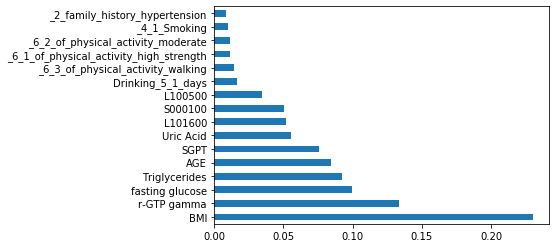

Index(['BMI', 'r-GTP gamma', 'fasting glucose', 'Triglycerides', 'AGE', 'SGPT',
       'Uric Acid', 'L101600', 'S000100', 'L100500', 'Drinking_5_1_days',
       '_6_3_of_physical_activity_walking',
       '_6_1_of_physical_activity_high_strength',
       '_6_2_of_physical_activity_moderate', '_4_1_Smoking',
       '_2_family_history_hypertension'],
      dtype='object')
0.9809304358683774


In [65]:
ypred = rf.predict(test.iloc[:, :-1])

score = rf.score(test.iloc[:, :-1], test.iloc[:, -1])
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, :-1].columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

print(np.sum(feat_importances.nlargest(16)))

In [66]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test.iloc[:, -1], ypred)

array([[575, 179, 109],
       [214, 299, 329],
       [ 90, 150, 591]], dtype=int64)

In [67]:
print(
    "Accuracy on training set: {:.3f}".format(
        rf.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(rf.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
ypred = rf.predict(test.iloc[:, :-1])

confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], ypred))
confmatrx.head()

Accuracy on training set: 0.650
Accuracy on test set: 0.578


,0,1,2
0,575,179,109
1,214,299,329
2,90,150,591


In [68]:
from sklearn.metrics import classification_report

print(classification_report(test.iloc[:, -1], ypred))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       863
           1       0.48      0.36      0.41       842
           2       0.57      0.71      0.64       831

    accuracy                           0.58      2536
   macro avg       0.57      0.58      0.57      2536
weighted avg       0.57      0.58      0.57      2536



In [69]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=randomseed, num_class=3)

xgb_model.fit(train.iloc[:, :-1], train.iloc[:, -1])

y_pred = xgb_model.predict((test.iloc[:, :-1]))

print("accuracy \t", m.accuracy_score(test.iloc[:, -1], y_pred))
confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], y_pred))
confmatrx.head()

accuracy 	 0.5792586750788643


,0,1,2
0,578,173,112
1,223,301,318
2,81,160,590


In [70]:
print(classification_report(test.iloc[:, -1], y_pred))

              precision    recall  f1-score   support

           0       0.66      0.67      0.66       863
           1       0.47      0.36      0.41       842
           2       0.58      0.71      0.64       831

    accuracy                           0.58      2536
   macro avg       0.57      0.58      0.57      2536
weighted avg       0.57      0.58      0.57      2536



===============================
==========